# Decaying network (parrot neurons)


- a network of 100 excitatory cells without any recurrent connections and inhibitions

In [1]:
# fileName

fileName = 'eg_decaying-network' 

In [2]:
# libs

import pyNN.brian2 as sim
from pyNN import space 
import numpy as np
import matplotlib.pyplot as plt


In [3]:
# simulation settings

sim.setup(
        timestep=1, # [ms]
        min_delay=1, # [ms]
        max_delay=100) # [ms]

simtime = 250 #ms

In [4]:
# defining the network

pops = {}
n_cells = {}
neuron_Model = {}
neuron_ModelPars = {}
initial_Values = {}

for popName in ['network']:
    n_cells[popName] = 100
    neuron_Model[popName] = sim.IF_cond_exp
    neuron_ModelPars[popName] = sim.IF_cond_exp.default_parameters # or standard_pars or testing_pars
    initial_Values[popName] = sim.IF_cond_exp.default_initial_values
    pops[popName] = sim.Population(n_cells[popName], 
                                   neuron_Model[popName],
                                   neuron_ModelPars[popName],
                                   structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                                   label = popName)

    pops[popName].record(['spikes','v','gsyn_exc','gsyn_inh'])   
 


array([40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56,
       57, 58, 59])

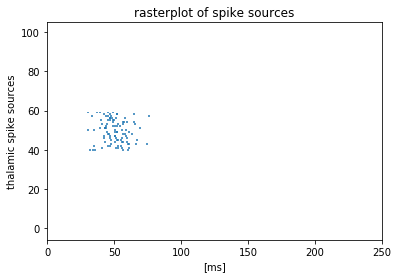

In [5]:
# make the thalamic input sources

popName = 'Thalamus'  

n_cells[popName] = n_cells['network']
spike_times = [[]]*n_cells[popName] #list of spike lists, where one spike list is related to one spike source
#random_sources_idx = [np.random.randint(n_cells[popName]*0.40, n_cells[popName]*0.60) for i in range(n_cells[popName])]
random_sources_idx = np.arange(int(n_cells[popName]*0.40), int(n_cells[popName]*0.60))

for idx, sources in enumerate(random_sources_idx):
    spike_times[sources] = np.sort([abs(np.random.normal(loc=50, scale=10)) for n in range(5)])

neuron_Model[popName] = sim.SpikeSourceArray(spike_times=spike_times)


pops[popName] = sim.Population(n_cells[popName], 
                               neuron_Model[popName],
                               structure = space.Line(dx=1.0, x0=0.0, y=0.0, z=0.0),
                               label = popName)

proj = {}
proj['Thalamus', 'network'] = sim.Projection(pops['Thalamus'], 
                                         pops['network'],
                                         connector = sim.OneToOneConnector(),
                                         synapse_type = sim.StaticSynapse(weight=0.08, delay=1),
                                         space = space.Space(axes = 'x'),
                                         receptor_type = 'excitatory',
                                         label = 'thalamus-network connections')

fig, axes = plt.subplots(1,1)
axes_list = fig.axes
axes_list[0].eventplot(spike_times)
axes_list[0].set_xlabel('[ms]')
axes_list[0].set_ylabel('thalamic spike sources')
axes_list[0].set_title('rasterplot of spike sources')
axes_list[0].set_xlim(0, simtime)

random_sources_idx

In [6]:
# run simulation

sim.run(simtime) 

INFO       No numerical integration method specified for group 'neurongroup', using method 'euler' (took 0.05s, trying other methods took 0.25s). [brian2.stateupdaters.base.method_choice]
WARNING    Note that the synaptic pathway 'synapses_pre' will run on the clock of the group 'spikegeneratorgroup' using a dt of 100. us. Either the Synapses object 'synapses' or the target 'neurongroup' (or both) are using a different dt. This might lead to unexpected results. In particular, all delays will be rounded to multiples of 100. us. If in doubt, try to ensure that 'spikegeneratorgroup', 'synapses', and 'neurongroup' use the same dt. [brian2.synapses.synapses.synapses_dt_mismatch]


250.0

In [7]:
# save the results
outputs = {}

for layer in ['network']:
    outputs[layer] = pops[layer].get_data()
    for recording in ['v', 'gsyn_inh', 'gsyn_exc', 'spikes']:
        pops[layer].write_data(fileName + '_' + str(layer) + '_' + str(recording) + '.pkl')

In [8]:
# check results

def recover_results(outputs):
    results = {}
    for key in outputs.keys(): # to extract the name of the layer, e.g., Exc, Inh, Thalamus, etc  
        
        # to get voltage and conductances
        for analogsignal in outputs[key].segments[0].analogsignals:
            print(analogsignal.name)
            results[key, analogsignal.name] = analogsignal

        # to get spikes
        results[key, 'spikes'] = outputs[key].segments[0].spiketrains
    return results

results = recover_results(outputs)
results.keys()

v
gsyn_exc
gsyn_inh


dict_keys([('network', 'v'), ('network', 'gsyn_exc'), ('network', 'gsyn_inh'), ('network', 'spikes')])

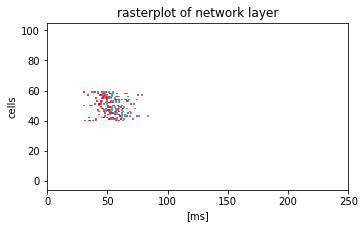

In [9]:
# check the spikes

fig, axes = plt.subplots(1, 1)
fig.tight_layout(pad=5)
axes_list = fig.axes

for idx, value in enumerate(['network']):
    axes_list[idx].eventplot(results[value, 'spikes'])
    axes_list[idx].eventplot(spike_times, color='r')
    axes_list[idx].set_title('rasterplot of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('[ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)


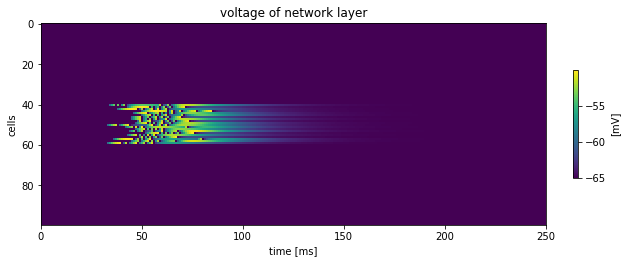

In [10]:
# check the voltage

fig, axes = plt.subplots(1, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['network']):
    im = axes_list[idx].imshow(results[value, 'v'].T)
    axes_list[idx].set_title('voltage of ' + str(value) + ' layer')
    axes_list[idx].set_xlabel('time [ms]')
    axes_list[idx].set_ylabel('cells')
    axes_list[idx].set_xlim(0, simtime)
    fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[mV]')

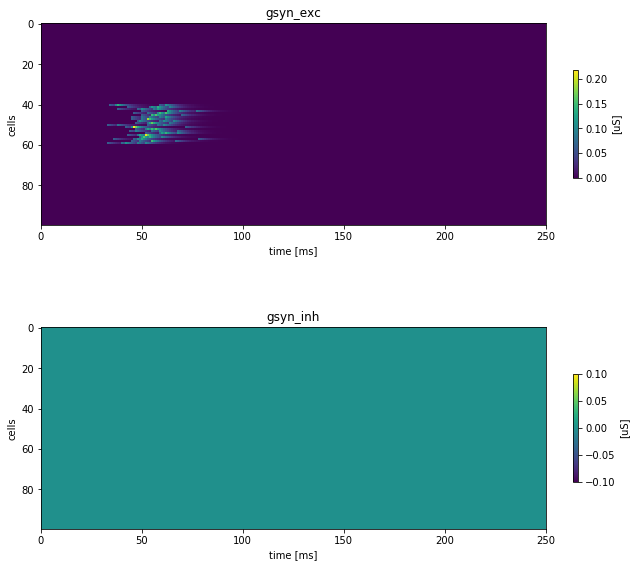

In [11]:
# check the conductances

# check the voltage

fig, axes = plt.subplots(2, 1, figsize=(9,9))
fig.tight_layout(pad=4)

axes_list = fig.axes

for idx, value in enumerate(['network']):
    for idx, gsyn in enumerate(['gsyn_exc', 'gsyn_inh']):
        im = axes_list[idx].imshow(results['network', gsyn].T)
        axes_list[idx].set_title(str(gsyn))
        axes_list[idx].set_xlabel('time [ms]')
        axes_list[idx].set_ylabel('cells')
        axes_list[idx].set_xlim(0, simtime)
        fig.colorbar(im, ax=axes_list[idx], fraction=0.010, label='[uS]')

In [12]:
# end simulation

sim.end()